# Convolution Neural Network 

In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_15812\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


In [32]:
def get_engine_status(row):
    # Get DTC_NUMBER and TROUBLE_CODES as strings (handle missing values)
    dtc = str(row['DTC_NUMBER']).strip() if pd.notnull(row['DTC_NUMBER']) else ""
    tc = str(row['TROUBLE_CODES']).strip() if pd.notnull(row['TROUBLE_CODES']) else ""
    # Rule:
    # If DTC_NUMBER equals "MIL is OFF1" OR TROUBLE_CODES is nonblank and starts with "P", then malfunctioning.
    if dtc == "MIL is OFF1" or (tc != "" and tc.upper().startswith("P")):
        return 1  # malfunctioning
    else:
        return 0  # healthy

In [33]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [34]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 'TIMING_ADVANCE', 
    'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]
df_model = df[ feature_cols + ['DTC_NUMBER', 'TROUBLE_CODES'] ].copy()

df_model['EngineStatus'] = df_model.apply(get_engine_status, axis=1)

# df_model.dropna(subset=['EngineStatus'], inplace=True) # drop rows with missing target

In [35]:
X = df_model[feature_cols]
y = df_model['EngineStatus']

In [36]:
meta_info = df_model[['DTC_NUMBER', 'TROUBLE_CODES']]

In [37]:
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [38]:
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y, meta_info, test_size=0.2, random_state=42
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [39]:
# reshape for CNN model
input_dim = X_train_processed.shape[1]
X_train_cnn = np.expand_dims(X_train_processed, axis=-1)  # Shape: (n_samples, input_dim, 1)
X_test_cnn = np.expand_dims(X_test_processed, axis=-1)
print(X_train_cnn.shape, X_test_cnn.shape)

(38011, 38, 1) (9503, 38, 1)


### Building the CNN model

In [40]:
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\raksh\anaconda3\envs\unet_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Train the Model

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9701 - loss: 0.0903 - val_accuracy: 0.9936 - val_loss: 0.0205
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9947 - loss: 0.0187 - val_accuracy: 0.9957 - val_loss: 0.0157
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9954 - loss: 0.0161 - val_accuracy: 0.9958 - val_loss: 0.0146
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9955 - loss: 0.0148 - val_accuracy: 0.9958 - val_loss: 0.0140
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9961 - loss: 0.0133 - val_accuracy: 0.9957 - val_loss: 0.0141
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9957 - val_loss: 0.0139
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9960 - loss: 0.0134 - val_accuracy: 0.9957 - val_loss: 0.0138
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9960 - loss: 0.0123 - val_accuracy: 0.

### Evaluation of the model

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9959 - loss: 0.0133
CNN Test Loss: 0.0128, CNN Test Accuracy: 0.9964
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


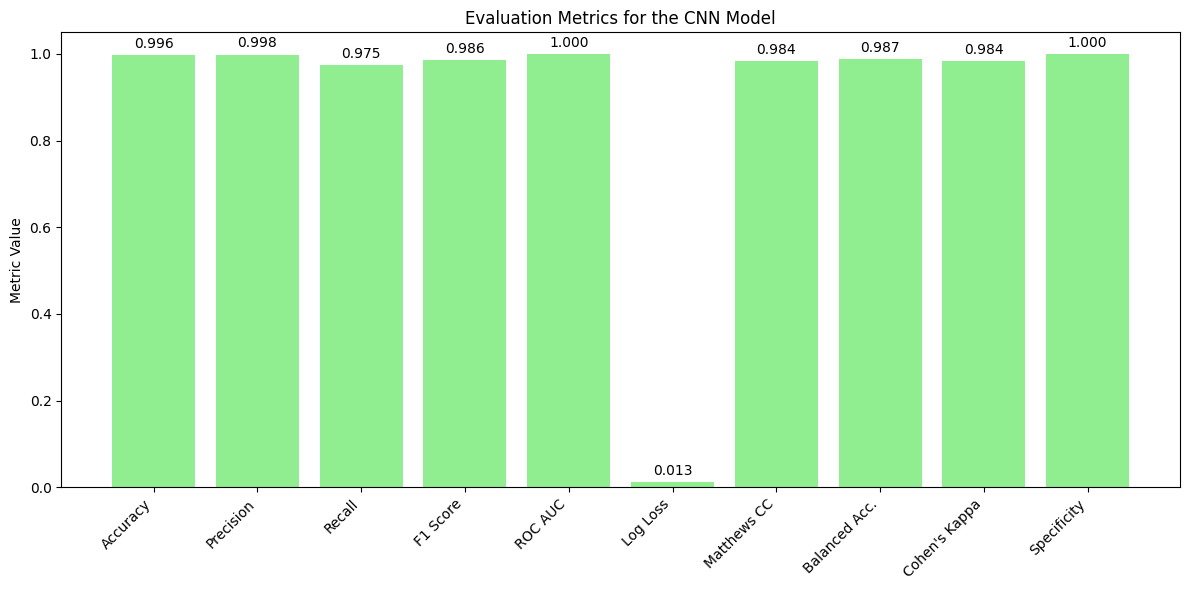

Sample 15805: Prediction: No malfunctioning
Sample 33942: Prediction: No malfunctioning
Sample 14577: Prediction: No malfunctioning
Sample 6113: Prediction: No malfunctioning
Sample 28348: Prediction: No malfunctioning
Sample 15039: Prediction: No malfunctioning
Sample 40224: Prediction: No malfunctioning
Sample 13197: Prediction: No malfunctioning
Sample 39394: Prediction: No malfunctioning
Sample 13988: Prediction: No malfunctioning
Sample 37140: Prediction: No malfunctioning
Sample 32396: Prediction: No malfunctioning
Sample 31374: Prediction: No malfunctioning
Sample 5692: Prediction: No malfunctioning
Sample 43455: Prediction: No malfunctioning
Sample 8761: Prediction: No malfunctioning
Sample 32445: Prediction: No malfunctioning
Sample 41419: Prediction: No malfunctioning
Sample 40145: Prediction: No malfunctioning
Sample 20831: DTC_NUMBER: MIL is OFF1 codes, TROUBLE_CODES: P0133 -> Prediction: Malfunctioning
Sample 30899: Prediction: No malfunctioning
Sample 21109: DTC_NUMBER: M

In [42]:
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test)
print(f'CNN Test Loss: {test_loss_cnn:.4f}, CNN Test Accuracy: {test_accuracy_cnn:.4f}')

y_pred_proba_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_proba_cnn >= 0.5).astype(int).flatten()
acc = accuracy_score(y_test, y_pred_cnn)
prec = precision_score(y_test, y_pred_cnn)
rec = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)
roc_auc = roc_auc_score(y_test, y_pred_proba_cnn)
ll = log_loss(y_test, y_pred_proba_cnn)
mcc = matthews_corrcoef(y_test, y_pred_cnn)
bal_acc = balanced_accuracy_score(y_test, y_pred_cnn)
kappa = cohen_kappa_score(y_test, y_pred_cnn)
cm = confusion_matrix(y_test, y_pred_cnn)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_dict_cnn = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}

plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict_cnn.keys(), metrics_dict_cnn.values(), color='lightgreen')
plt.title("Evaluation Metrics for the CNN Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

predictions_df = meta_test.copy()
predictions_df['Predicted_Status'] = y_pred_cnn
predictions_df['Prediction'] = predictions_df['Predicted_Status'].apply(
    lambda x: "Malfunctioning" if x == 1 else "No malfunctioning"
)

# Print predictions: if malfunctioning, display DTC_NUMBER and TROUBLE_CODES; otherwise, print "No malfunctioning."
for idx, row in predictions_df.iterrows():
    if row['Predicted_Status'] == 1:
        print(f"Sample {idx}: DTC_NUMBER: {row['DTC_NUMBER']}, TROUBLE_CODES: {row['TROUBLE_CODES']} -> Prediction: Malfunctioning")
    else:
        print(f"Sample {idx}: Prediction: No malfunctioning")